In [201]:
from pydub import AudioSegment
from pydub.utils import mediainfo
from scipy import signal
from scipy import spatial
from glob import glob
from IPython.display import Audio
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os

In [2]:
path = '../fma_small/000/*.mp3'
music = [AudioSegment.from_file(files) for files in glob(path)]

/Users/wjr/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7739: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


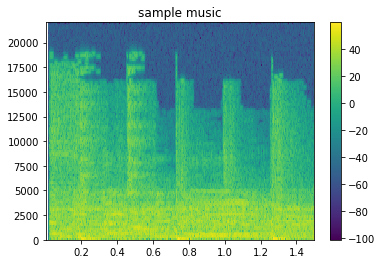

(129, 515)


In [3]:
sample = np.array(music[0].get_array_of_samples())
sample = [sample[i] for i in range(0,3*44100,2)] #get left channel only
Fs = music[0].frame_rate
sample = sample[:int(Fs*1.5)]
spec, freqs, bins, im = plt.specgram(sample, Fs=Fs)
plt.colorbar()
plt.title('sample music')
plt.show()
print(spec.shape)

In [4]:
WIDTH = 128
HEIGHT = 512
LENGTH = int(1.5*Fs)
INPUT_LEN = 30*Fs
INTERVAL = int(0.05*Fs) #in seconds, determines how many fingerprints each song will generate

def _parse_audio(music, path, k=None):
    ## music: raw music array from file
    ## path: path that contains the label of the music
    ## k: batch size
    batch = []
    label = []
    for i in range(len(music)):
        temp = np.array(music[i].get_array_of_samples())
        if len(temp) > INPUT_LEN: #check if the audio has two channels
            temp = [temp[i] for i in range(0,len(temp),2)] #get left channel only
            
        # convert to fingerprints
        num_fp = int((len(temp)-LENGTH)/INTERVAL)+1
        for j in range(num_fp):
            segment = temp[j*INTERVAL:j*INTERVAL+LENGTH]
            cur_spec, freqs, bins, im = plt.specgram(segment, Fs=Fs)
            cur_spec = cur_spec[:WIDTH, :HEIGHT] #truncate to power of 2            
            batch.append(cur_spec)
        
        # discard last few elements
        # create label for the current music (modify so that only nearby segment have the same label)
        label += [int(str(glob(path)[i])[17:23])] * (num_fp)
    
    # shuffle all samples
    batch = np.asarray(batch)
    label = np.asarray(label)
    s = np.arange(batch.shape[0])
    np.random.shuffle(s)
    batch = batch[s]
    label = label[s]
    
    # create k-size batches
    if k != None:
        num_batch = int(batch.shape[0]/k)
        batch = batch[:num_batch*k]
        label = label[:num_batch*k]
        batch = batch.reshape(num_batch, k, WIDTH, HEIGHT, 1)
        label = label.reshape(num_batch, k)
        batch = [batch[i]/np.amax(batch[i]) for i in range(batch.shape[0])]

    return np.asarray(batch), np.asarray(label)

In [5]:
# only the first two music 
train_data, train_label = _parse_audio(music[:2], path, 50)

/Users/wjr/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7739: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


In [229]:
#train_data = train_data.astype(np.float32)
#train_data = train_data/np.amax(train_data)
#tag = mediainfo(glob(path)[0])
#print('music title: '+str(tag['TAG']['title'])+'\nbatch shape: '+str(train_data.shape))
dirs = glob('../fma_small/*')
path = [str(dirs[i]) + str('/*.mp3') for i in range(len(dirs))]

In [7]:
temppath = '../../Right Here Waiting.mp3'
sound = AudioSegment.from_file(temppath)
sample = np.array(sound.get_array_of_samples())
sample = sample[:20*Fs] #get left channel only
sample = [sample[i+1] for i in range(0,20*Fs,2)]
Audio(data=sample, rate=Fs)

In [42]:
MARGIN = 0.2

# helper function for triplet loss
def dist(x,y):
    diffs = tf.expand_dims(x, axis=1) - tf.expand_dims(y, axis=0)
    return tf.sqrt(tf.reduce_sum(tf.square(diffs), axis=-1))

def triplet_loss(dists, labels):
    identity_mask = tf.equal(tf.expand_dims(labels, axis=1),
                             tf.expand_dims(labels, axis=0))
    negative_mask = tf.logical_not(identity_mask)
    positive_mask = tf.logical_xor(identity_mask,
                                   tf.eye(tf.shape(labels)[0], dtype=tf.bool))

    furthest_positive = tf.reduce_max(dists*tf.cast(positive_mask, tf.float32), axis=1)
    closest_negative = tf.map_fn(lambda x: tf.reduce_min(tf.boolean_mask(x[0], x[1])),
                                (dists, negative_mask), tf.float32)
    
    diff = furthest_positive - closest_negative
    
    return tf.maximum(diff + MARGIN, 0.0)

In [193]:
NUM_EMBEDDING = 64
SPLIT = 8

def model(features):
    # convolution layer 1 input: 128*512
    conv11 = tf.layers.conv2d(
        inputs=features,
        filters=32,
        kernel_size=[1,3],
        padding="same",
        activation=tf.nn.relu)
    
    conv12 = tf.layers.conv2d(
        inputs=conv11,
        filters=32,
        kernel_size=[3,1],
        padding="same",
        activation=tf.nn.relu)
    
    # pooling layer 1
    pool1 = tf.layers.max_pooling2d(inputs=conv12, pool_size=[2,2], strides=2)
    
    # convolution layer 2 input: 64*256
    conv21 = tf.layers.conv2d(
        inputs=pool1,
        filters=32,
        kernel_size=[1,3],
        padding="same",
        activation=tf.nn.relu)
    
    conv22 = tf.layers.conv2d(
        inputs=conv21,
        filters=32,
        kernel_size=[3,1],
        padding="same",
        activation=tf.nn.relu)
    
    # pooling layer 2
    pool2 = tf.layers.max_pooling2d(inputs=conv22, pool_size=[2,2], strides=2)
    
    # convolution layer 3 input: 32*128
    conv31 = tf.layers.conv2d(
        inputs=pool2,
        filters=32,
        kernel_size=[1,3],
        padding="same",
        activation=tf.nn.relu)
    
    conv32 = tf.layers.conv2d(
        inputs=conv31,
        filters=32,
        kernel_size=[3,1],
        padding="same",
        activation=tf.nn.relu)
    
    # pooling layer 2
    pool3 = tf.layers.max_pooling2d(inputs=conv32, pool_size=[2,2], strides=2)
    
    ### more convolution layers here...
    
    # flatten input: 16*64=1024
    flat = tf.layers.flatten(pool3)

    ### divide and encode...
    concatenate = []
    num_each_split = flat.shape[-1]//SPLIT
    units = NUM_EMBEDDING//SPLIT
    splits = tf.split(flat, SPLIT, 1)

    for i in range(SPLIT):
        print(i)
        divide = tf.layers.dense(splits[i], activation=tf.nn.relu, units=128)
        divide = tf.layers.dense(divide, activation=tf.nn.relu, units=units)
        concatenate.append(divide)
    
    embedding = tf.concat([elem for elem in concatenate], 1)
    print(embedding)
    # final embedding
    #embedding = tf.layers.dense(flat,
                                #activation=None,
                                #kernel_initializer=tf.truncated_normal_initializer,
                                #units=NUM_EMBEDDING)
    
    return embedding

In [194]:
input_data = tf.placeholder(tf.float32, [None, WIDTH, HEIGHT, 1])
input_label = tf.placeholder(tf.int32, [None])

# loss function operations
embedded = model(input_data)
dists = dist(embedded, embedded)
loss = tf.reduce_mean(triplet_loss(dists, input_label))

# train operation
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_op = optimizer.minimize(
    loss=loss,
    global_step=tf.train.get_global_step())
init = tf.global_variables_initializer()

0
1
2
3
4
5
6
7
Tensor("concat_12:0", shape=(?, 64), dtype=float32)


In [11]:
num_epoch = 1
sess = tf.Session()
sess.run(init)
    
loss_hist = []
    
for i in range(num_epoch):
    # _parse_audio(music)
    for j in range(train_data.shape[0]):
        _, loss_val = sess.run([train_op, loss],
                                feed_dict={input_data: train_data[j],
                                           input_label: train_label[j]})
        loss_hist.append(loss_val)
        print('batch num: '+str(j))
    print('num_epoch: '+str(i))

batch num: 0
batch num: 1
batch num: 2
batch num: 3
batch num: 4
batch num: 5
batch num: 6
batch num: 7
batch num: 8
batch num: 9
batch num: 10
batch num: 11
batch num: 12
batch num: 13
batch num: 14
batch num: 15
batch num: 16
batch num: 17
batch num: 18
batch num: 19
batch num: 20
batch num: 21
num_epoch: 0


In [92]:
# predict mode
#similar = 1 - [spatial.distance.cosine(ref, embedding) for ref in embedding_vec]
#similar = tf.constant(1.0) - [tf.losses.cosine_distance(tf.nn.l2_normalize(ref, 0), tf.nn.l2_normalize(embedding[-1], 0), axis=0) for ref in embedding_vec]
embeddings = sess.run([embedded], feed_dict={input_data: train_data[0][:10]})
#print('first three embeddings: '+str(embeddings[0]))
print('\nloss history:'+str(loss_hist))
print('\nfirst three labels: '+str(train_label[0][:10]))


loss history:[0.7504821, 1.1608878, 0.84255433, 0.78621846, 0.717238, 0.53365827, 0.5064337, 0.4895173, 0.56863314, 0.49041438, 0.504495, 0.43045497, 0.5283757, 0.32212675, 0.39548576, 0.3757723, 0.2148812, 0.24846286, 0.15727802, 0.23708595, 0.20059584, 0.11411814]

first three labels: [212  10 212  10  10 212  10 212 212  10]


In [93]:
threshold = 1000
def similarity(query, embeds):
    distance = [spatial.distance.cosine(ref, query) for ref in embeds]
    sim = 1 - threshold * np.asarray(distance)
    return sim
similarity(embeddings[0][0], embeddings[0])

array([ 1.        , -0.58548355,  0.90081787,  0.06766415, -0.34497881,
        0.9294281 , -0.32316351,  0.87792969,  0.9165535 , -0.42014027])

In [71]:
def test(dists, labels):
    print('dist:\n'+str(dists.eval()))
    identity_mask = tf.equal(tf.expand_dims(labels, axis=1),
                             tf.expand_dims(labels, axis=0))
    print('\nidentity mask:\n'+str(identity_mask.eval()))
    negative_mask = tf.logical_not(identity_mask)
    positive_mask = tf.logical_xor(identity_mask,
                                   tf.eye(tf.shape(labels)[0], dtype=tf.bool))
    print('\nnegative mask:\n'+str(negative_mask.eval()))
    print('\npositive mask:\n'+str(positive_mask.eval()))

    furthest_positive = tf.reduce_max(dists*tf.cast(positive_mask, tf.float32), axis=1)
    closest_negative = tf.map_fn(lambda x: tf.reduce_min(tf.boolean_mask(x[0], x[1])),
                                (dists, negative_mask), tf.float32)
    print('\nfurthest positive:\n'+str(furthest_positive.eval()))
    print('\ncloest negative:\n'+str(closest_negative.eval()))
    
    diff = furthest_positive - closest_negative
    
    return tf.maximum(diff + MARGIN, 0.0)


a = [[0.0,1.0,-2.0],[-3.0,4.0,5.0],[-5.0,3.0,3.5]]
b = [1,1,0]
with sess.as_default():
    print('\n\nfinal result:'+str(test(dist(a,a),b).eval()))

dist:
[[0.        8.185352  7.697402 ]
 [8.185352  0.        2.6925824]
 [7.697402  2.6925824 0.       ]]

identity mask:
[[ True  True False]
 [ True  True False]
 [False False  True]]

negative mask:
[[False False  True]
 [False False  True]
 [ True  True False]]

positive mask:
[[False  True False]
 [ True False False]
 [False False False]]

furthest positive:
[8.185352 8.185352 0.      ]

cloest negative:
[7.697402  2.6925824 2.6925824]


final result:[0.6879503 5.69277   0.       ]


In [101]:
a = []
b = [1,2,3]
a += b
c = [4,5]
a += c
a

[1, 2, 3, 4, 5]